## PICKS

**link to the data:**
https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm

In [1]:
#!conda install pyspark
id_values = '2'

In [15]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.partitions import *
from utils.complete_missing_dates import *
from utils.df_transformations import *

# import necesary libraries
import os
import sys

#pyspark libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column, lit
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime
import pandas as pd
import numpy as np

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load data
modelDataFile = "data/data_bank/trans.asc"

df_input = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ";") \
  .load(modelDataFile)

In [30]:
df_input.show()

+--------+----------+------+------+-------------+------+-------+--------+----+--------+
|trans_id|account_id|  date|  type|    operation|amount|balance|k_symbol|bank| account|
+--------+----------+------+------+-------------+------+-------+--------+----+--------+
|  695247|      2378|930101|PRIJEM|        VKLAD| 700.0|  700.0|    null|null|    null|
|  171812|       576|930101|PRIJEM|        VKLAD| 900.0|  900.0|    null|null|    null|
|  207264|       704|930101|PRIJEM|        VKLAD|1000.0| 1000.0|    null|null|    null|
| 1117247|      3818|930101|PRIJEM|        VKLAD| 600.0|  600.0|    null|null|    null|
|  579373|      1972|930102|PRIJEM|        VKLAD| 400.0|  400.0|    null|null|    null|
|  771035|      2632|930102|PRIJEM|        VKLAD|1100.0| 1100.0|    null|null|    null|
|  452728|      1539|930103|PRIJEM|        VKLAD| 600.0|  600.0|    null|null|    null|
|  725751|      2484|930103|PRIJEM|        VKLAD|1100.0| 1100.0|    null|null|    null|
|  497211|      1695|930103|PRIJ

In [4]:
# Date transformation
df_input_date = (df_input.withColumn("orig_date", col("date").cast("string"))
                .withColumn("date", to_date(from_unixtime(unix_timestamp('orig_date', 'yyMMdd'))))
 .withColumn("date", to_date(from_unixtime(unix_timestamp('date', 'yyMMdd')))))

# Type of transaction: "PRIJEM" stands for credit and "VYDAJ" stands for withdrawal
df_trans = df_input_date.withColumn("is_expense", sf.when((col('type') == 'VYDAJ'), 1).otherwise(0))

# Select columns of interest
cols = ['trans_id', 'date','account_id','balance', 'amount','is_expense']
df_trans = df_trans.select(*cols)

#Montly partition (end of the month): because we aggregate the transactions of the month
df_trans = df_trans.withColumn('monthly_partition', create_partitions_from_df('date', "yyyy-MM-dd"))

#Sort by transaction id and date 
df_trans = df_trans.orderBy(["account_id", "date", "trans_id"], ascending = True)

## Group by Expenses & income
df_inc_exp = (df_trans.withColumn('income', sf.when(col('is_expense') == 0, col('amount')).otherwise(0))
             .withColumn('expense', sf.when(col('is_expense') == 1, col('amount')).otherwise(0)))
df_group = (df_inc_exp.groupBy("account_id", "monthly_partition")
                  .agg(sf.sum('income'), sf.sum('expense'), sf.count(sf.lit('monthly_partition')), sf.sum('is_expense'))
                  .withColumnRenamed('sum(income)', 'montly_income')
                 .withColumnRenamed('sum(expense)', 'montly_expense')
                 .withColumnRenamed('sum(is_expense)', 'n_mov_expense')
             .withColumnRenamed('count(monthly_partition)', 'n_mov_trans')
           )
## Include yar and month values
df_group = (df_group.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition'))
.withColumn('monthly_partition', col('monthly_partition').cast('string')))

##
## Complete data by year (the function that we have only works for one year at time) -> we have data from 1993-01 to 1998-12
# we will have missing months, months without expenses and incomes 
df_complet_year = (complete_missing_months(spark, df_group, 'monthly_partition', 'account_id'))
df_complet_year = df_complet_year.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).fillna(0)
#update
df_complet_year = (df_complet_year.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition')))

In [5]:
df_complet_year.filter(col('account_id') == id_values).sort('account_id', 'monthly_partition').show(200, False)

+-----------------+----------+-------------+------------------+-----------+-------------+----+-----+
|monthly_partition|account_id|montly_income|montly_expense    |n_mov_trans|n_mov_expense|year|month|
+-----------------+----------+-------------+------------------+-----------+-------------+----+-----+
|1993-01-31       |2         |0.0          |0.0               |0          |0            |1993|1    |
|1993-02-28       |2         |1100.0       |0.0               |1          |0            |1993|2    |
|1993-03-31       |2         |23949.5      |0.0               |3          |0            |1993|3    |
|1993-04-30       |2         |20345.5      |11000.0           |3          |1            |1993|4    |
|1993-05-31       |2         |20380.7      |17600.0           |3          |1            |1993|5    |
|1993-06-30       |2         |30513.9      |22400.0           |3          |1            |1993|6    |
|1993-07-31       |2         |33584.0      |13514.6           |6          |3            |19

In [6]:
#df_group.filter('''account_id = '11382' ''').sort('account_id', 'monthly_partition').show(20, False)

## **TREATMENTS:**

- Collect all the monthly available data of income/expenses at customer level.
- Collect seniority data at customer level.
    - Study those customers with seniority greater than the available data
    - Study those customers with seniority lower than the available data.
- Complete missing values (righ now we complete with zero, but the ideal would be the mean or the median)
- Multiply expenses to be mostly positive (remenber we have positive and negative values).


## **Question**

- If we detect the a pick is seasonal, do we really need to remove it?

Keep only seasonal structure from the serie.

## **Method 1**

- Take those examples with peaks. This is customers with accumulated expenses of
    - .withColumn("UpperLimit", col("mean") + col("stddev")*3)
    - .withColumn("LowerLimit", col("mean") - col("stddev")*3))

over the window of available data.
(we can adjust the number of standard deviations whatever we want)

- To this type of client we apply some king the smoothing to fix the point

## **Method 2**

- With respect to the incomes consider those expeses that are greater but much to the income of the customer.


![title](fig/val.png)

## **Method 3** (alternative to the Method 1)
- Change detection: 

## **Plot series**

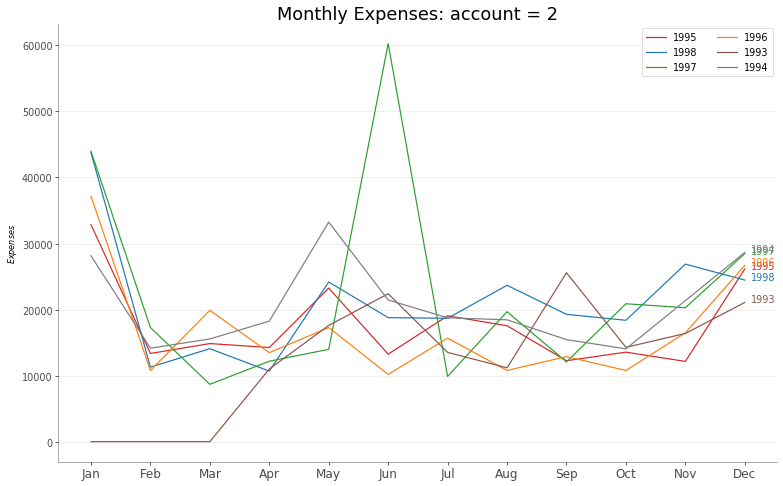

In [7]:
#transform data to pandas
df = df_complet_year.filter(col('account_id') == id_values).sort('month').toPandas()
# plot
title = "Monthly Expenses: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_expense'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

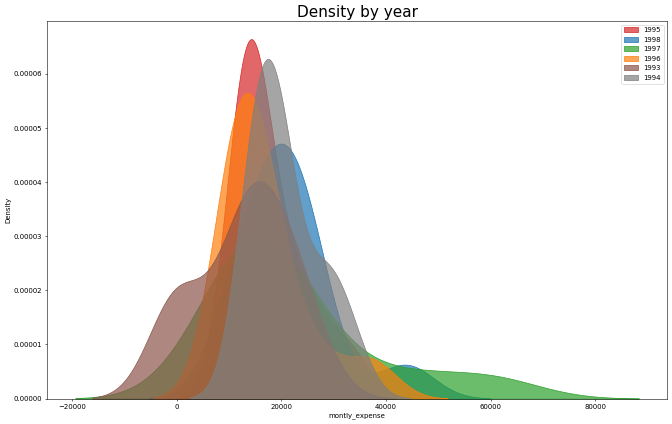

In [8]:
plot_density(df, "montly_expense", 'monthly_partition', 'Density by year')

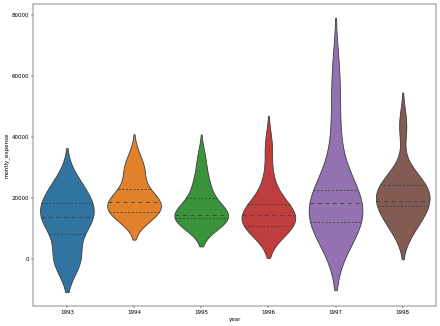

In [9]:
classes = 'year'
val =  'montly_expense'
title = ''
    
plot_violin(df, classes, val, title)

## **Outliers**

Regarding to who you are an outlier,  regarding to yourself, regarding to others in the same year. Explore the different alternatives.

In [10]:
df_group.count()

185057

In [11]:
#Outliers by account
#[change]: solve select
d_outliers = find_outliers(df_complet_year, comparison_column = ['account_id'], filed_value = 'montly_expense').sort('year')
print('number of outliers: ', d_outliers.count())
d_outliers.show(20, False)

number of outliers:  5355
+----------+----+--------------+-----------------+------------------+------------------+------------------+-------------------+---------+
|account_id|year|montly_expense|monthly_partition|mean              |stddev            |UpperLimit        |LowerLimit         |isOutlier|
+----------+----+--------------+-----------------+------------------+------------------+------------------+-------------------+---------+
|2434      |1993|25641.6       |1993-06-30       |5389.897222222221 |4262.600471244868 |18177.698635956825|-7397.904191512383 |true     |
|866       |1993|40965.6       |1993-06-30       |13315.211111111099|7206.025663926723 |34933.28810289127 |-8302.865880669067 |true     |
|2357      |1993|24523.6       |1993-06-30       |6011.683333333329 |4602.632427270657 |19819.5806151453  |-7796.213948478642 |true     |
|3834      |1993|43296.6       |1993-06-30       |15181.633333333324|8008.8846344825515|39208.287236780976|-8845.020570114331 |true     |
|9403   

## **Smoothing**

In [13]:
## Limits
d_limits = (df_complet_year.select('account_id', 'montly_expense', 'monthly_partition')
            .join( limits(df_group, comparison_column = ['account_id'], filed_value = 'montly_expense'), 'account_id', 'left').sort('account_id'))


In [21]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import numpy as np 
from pyspark.sql.types import FloatType


def rolling_metric(df, partitioned_by = "account_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3):
    """
    Rolling Median & Mean 
    """
    
    median_udf = udf(lambda x: float(np.median(x)), FloatType())

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, 1)) #windows months before, in the present month
    df = df.select("*", (F.mean(value).over(w2)).alias("rolling_avg_" + str(window_size) + "m"))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-(window_size - 1), 0))
    df = df.withColumn("list", collect_list("montly_expense").over(w2)) \
      .withColumn("rolling_median_" + str(window_size) + "m", median_udf("list").cast('double')).drop('date', 'rank') #'list', 
    
    return df

df_rolling = (rolling_metric(d_limits, partitioned_by = "account_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3))
(df_rolling.drop('mean', 'stddev', 'UpperLimit', 'LowerLimit').filter(col('account_id') == id_values).sort('monthly_partition').show(20, False))

+----------+------------------+-----------------+------------------+-------------------------------------------------+-----------------+
|account_id|montly_expense    |monthly_partition|rolling_avg_3m    |list                                             |rolling_median_3m|
+----------+------------------+-----------------+------------------+-------------------------------------------------+-----------------+
|2         |0.0               |1993-01-31       |0.0               |[0.0]                                            |0.0              |
|2         |0.0               |1993-02-28       |0.0               |[0.0, 0.0]                                       |0.0              |
|2         |0.0               |1993-03-31       |2750.0            |[0.0, 0.0, 0.0]                                  |0.0              |
|2         |11000.0           |1993-04-30       |5720.0            |[0.0, 0.0, 11000.0]                              |0.0              |
|2         |17600.0           |1993-05-31

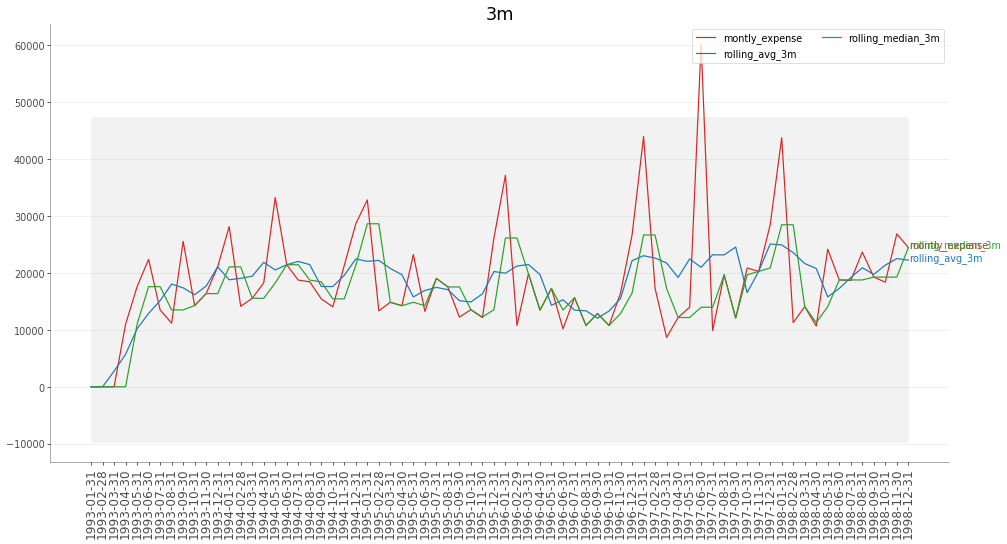

In [22]:
#3m
df = to_explode(df_rolling.select('monthly_partition', 'account_id', 'montly_expense', 'rolling_avg_3m', 'rolling_median_3m'), ['monthly_partition', 'account_id'])
df = df.filter(col('account_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('account_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='3m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

In [24]:
#2m
df_rolling = (rolling_metric(d_limits, partitioned_by = "account_id", value = "montly_expense", date_field = "monthly_partition", window_size = 2))
(df_rolling.drop('mean', 'stddev', 'UpperLimit', 'LowerLimit').filter(col('account_id') == id_values).sort('monthly_partition').show(20, False))

+----------+------------------+-----------------+------------------+----------------------------------------+-----------------+
|account_id|montly_expense    |monthly_partition|rolling_avg_2m    |list                                    |rolling_median_2m|
+----------+------------------+-----------------+------------------+----------------------------------------+-----------------+
|2         |0.0               |1993-01-31       |0.0               |[0.0]                                   |0.0              |
|2         |0.0               |1993-02-28       |0.0               |[0.0, 0.0]                              |0.0              |
|2         |0.0               |1993-03-31       |2750.0            |[0.0, 0.0]                              |0.0              |
|2         |11000.0           |1993-04-30       |7150.0            |[0.0, 11000.0]                          |5500.0           |
|2         |17600.0           |1993-05-31       |12750.0           |[11000.0, 17600.0]                  

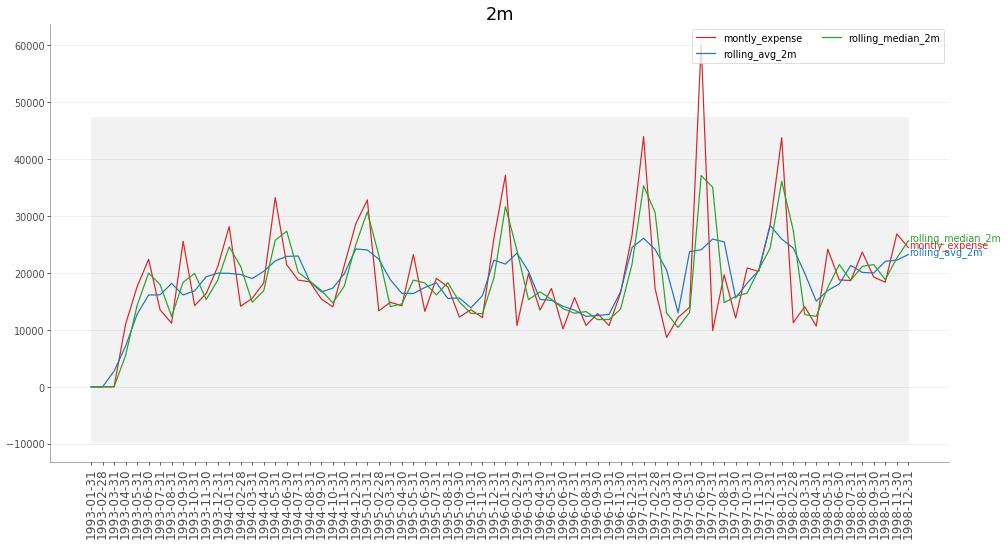

In [25]:
df = to_explode(df_rolling.select('monthly_partition', 'account_id', 'montly_expense', 'rolling_avg_2m', 'rolling_median_2m'), ['monthly_partition', 'account_id'])
df = df.filter(col('account_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('account_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='2m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

## **Income**

- If we have a expense that is due to an increase in income ¿is it a pick?
- We can have the case of persons that does not have severla incomes, these are not equal. 

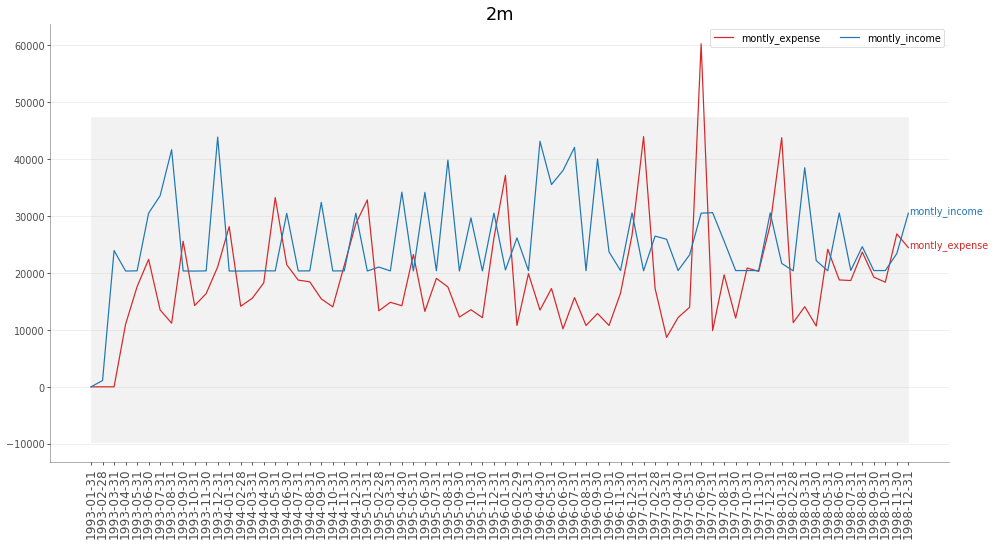

In [26]:
df = to_explode(df_complet_year.select('monthly_partition', 'account_id', 'montly_expense', 'montly_income'), ['monthly_partition', 'account_id'])
df = df.filter(col('account_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('account_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='2m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

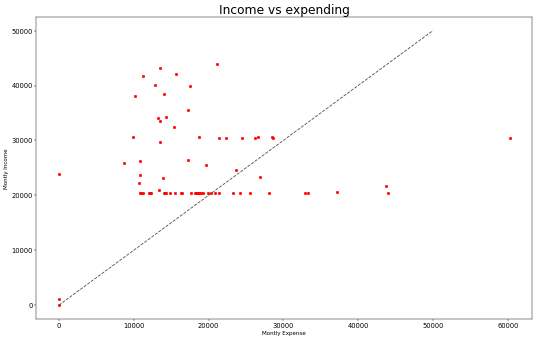

In [27]:
import math 
df_complet_year_proy = (df_complet_year.select('account_id', 'montly_income', 'montly_expense')
 .withColumn('proyection', col('montly_expense')*math.cos(45)))

title = "Income vs expending"
x_label = 'Montly Expense' 
y_label = 'Montly Income'
x_field = 'montly_expense'
y_field = 'montly_income' 


df = df_complet_year.filter(col('account_id') == id_values).toPandas()
scatter_plot(df, x_field, y_field, title, x_label, y_label, dpi =40 )

In [28]:
## Scatter

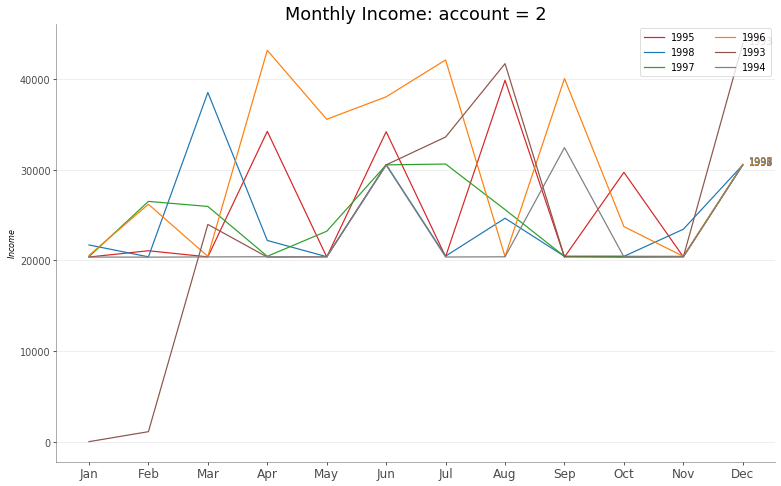

In [29]:
#transform data to pandas
df = df_complet_year.filter(col('account_id') == id_values).sort('month').toPandas()
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_income'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## **Change detection**

https://github.com/BMClab/BMC/blob/master/notebooks/DetectCUSUM.ipynb

In [ ]:
df_group.show(2, False)

In [ ]:
#just for now but we need to complete the data

df_group_2 = df_group.sort('account_id', 'monthly_partition').filter(col('account_id') == id_values)

In [ ]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
df_group_2 = df_group_2.withColumn('sum_amount_lag', lag('sum_amount').over(
            Window.partitionBy('account_id').orderBy('monthly_partition')))

In [ ]:
df_group_2.sort('account_id', 'monthly_partition').show(5, False)

In [ ]:
df_group_2 = df_group_2.withColumn('s_pos', col('sum_amount_lag') - col('sum_amount')).withColumn('cumsum', sf.sum('s_pos').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('s_neg', - col('sum_amount_lag') + col('sum_amount')).withColumn('cumsum', sf.sum('s_neg').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('g_neg', sf.when(col('s_neg')> 0, col('s_neg')).otherwise(0))
df_group_2 = df_group_2.withColumn('g_pos', sf.when(col('s_pos')> 0, col('s_pos')).otherwise(0))
df_group_2.show(20, False)                                                                                  

In [ ]:
df_g = df_group_2.toPandas()
plt.plot(df_g['monthly_partition'], df_g['g_neg'], c = 'b', label = 'g_neg')
plt.plot(df_g['monthly_partition'], df_g['g_pos'], c = 'r', label = 'g_pos')
#plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
#plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
#plt.plot(mean_minus_std, 'k--')
#plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()